# Notebook configuration

In [1]:
run_numbers         = 4583, 4584, 4587, 4588
data_type           = "Cs137"
input_pattern       = "/Users/Gonzalo/github/NEXTdata/{}/dst_{}.root.h5"
output_folder       = "plots/{}/{}/".format(data_type, run_numbers)
plots_format        = "png"
save_plots          = False
corr_pitch          = 5.3 # 4.0, 5.3, 7.9, 15.8
correction_filename = "/Users/Gonzalo/github/NEXTdata/XYmaps/run4446_corrections_{:.1f}mm.h5"

Zrange              =     0, 600
XYrange             =  -198, 198
Rrange              =     0, max(XYrange)
Prange              =  -3.2, 3.2  
Qrange              =     0, 5e2
QErange             =     0, 0.1
Frange              =   0.8, 1.5
Urange              =  1e-2, 1e-1

NSirange            =     0, 30
fixed_lifetime      = False

nbins_LT            =    10
Zrange_LT           =    50, 520
Zrange_XY           =     0, 520
nX, nY, nZ, nR      =    50,  50,  50,  50

XR_range            =   6e3,  12e3
PP_range            = 160e3, 220e3
full_range          =     0, 230e3

XR_fit_range        =  8200, 12000
PP_fit_range        = 170e3, 205e3

XR1_fit_seed        =  8500
XR2_fit_seed        = 10000
PP1_fit_seed        = 198e3
PP2_fit_seed        = 190e3

XR1_energy_keV      = 29.7
XR2_energy_keV      = 33.8

PP1_energy_keV      = 662
PP2_energy_keV      = PP1_energy_keV - XR1_energy_keV

Qbb_energy_keV      = 2458

# Imports

In [2]:
import os
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  . dst_io        as dstio
import invisible_cities.io  .kdst_io        as kdstio
import invisible_cities.reco.corrections    as corrf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import pdf
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import display_matrix
from invisible_cities.icaro.hst_functions import covariance
from invisible_cities.icaro.hst_functions import resolution
from invisible_cities.icaro.hst_functions import gausstext
from invisible_cities.icaro.hst_functions import measurement_string
from invisible_cities.icaro.hst_functions import shift_to_bin_centers
from invisible_cities.icaro.hst_functions import poisson_sigma
from invisible_cities.icaro.hst_functions import plot_writer

pi   = np.pi
save = plot_writer(save_to_folder, outputfolder) if save_plots else lambda *x: None

Running on  Wed Sep  6 13:35:32 2017


# Plotting options

In [3]:
%matplotlib inline
np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"         ] = 8, 6
plt.rcParams["figure.max_open_warning"] = 100
plt.rcParams["font.size"              ] = 15

data0_draw_opt      = "kp"
data1_draw_opt      = "mp"
data2_draw_opt      = "cp"
prof_draw_opt       = "kp--"
bkg_fit_draw_opt    = "g-"
global_fit_draw_opt = "r-"
peak_1_fit_draw_opt = "k-"
peak_2_fit_draw_opt = "b-"

# Initialization

In [4]:
XYcorrection    = dstf .load_xy_corrections(correction_filename.format(corr_pitch))
save            = plot_writer(output_folder, plots_format)

full_range_bins = np.linspace(*full_range, 100)
XR_range_bins   = np.linspace(*  XR_range, 100)
PP_range_bins   = np.linspace(*  PP_range, 100)
Zbins           = np.linspace(*    Zrange,  nZ)

full_bin_size   = np.diff(full_range_bins)[0]
XR_bin_size     = np.diff(  XR_range_bins)[0]
PP_bin_size     = np.diff(  PP_range_bins)[0]

resolution_at_xr_string  = "Resolution at {: <4} keV:".format(XR1_energy_keV)
resolution_at_pp_string  = "Resolution at {: <4} keV:".format(PP1_energy_keV)
resolution_at_qbb_string = "Resolution at {: <4} keV:".format(Qbb_energy_keV)
chi2_string              = "Chi2{}:".format(" "*18) 

# Read data

In [5]:
full = dstio.load_dsts([input_pattern.format(data_type, run) for run in run_numbers], "DST", "Events")
full = full[full.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(full))
full.head()

567537


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.502133e+09,0,1,175.0,16.573950,87.241216,894475.0,11.904375,21740.093750,...,1004237.5,165,109.7625,109.7625,47.603783,77.530381,90.978460,1.020145,31.323017,36.885737
1,2,1.502133e+09,0,1,200.0,32.077038,170.348656,699725.0,47.575000,10744.871094,...,1031512.5,104,331.7875,331.7875,-112.945256,11.553912,113.534681,3.039651,21.261901,19.700598
2,3,1.502133e+09,0,1,175.0,26.533182,136.164050,836625.0,24.792500,14396.042969,...,1010537.5,172,173.9125,173.9125,-87.326647,12.513034,88.218588,2.999271,30.138869,28.408456
3,4,1.502133e+09,0,1,175.0,27.880442,145.312320,882200.0,41.883750,18183.529297,...,1012212.5,167,130.0125,130.0125,-132.275213,-0.487388,132.276111,-3.137908,25.411981,24.213981
4,5,1.502133e+09,0,1,150.0,18.638519,89.657207,982125.0,16.535688,20698.324219,...,1012412.5,96,30.2875,30.2875,4.912402,-59.092401,59.296235,-1.487856,21.662886,22.386061


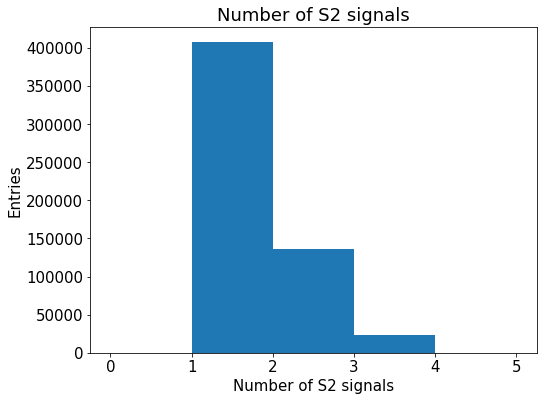

In [6]:
hist(full.nS2, 5, (0, 5))
labels("Number of S2 signals", "Entries", "Number of S2 signals")
save("NS2")

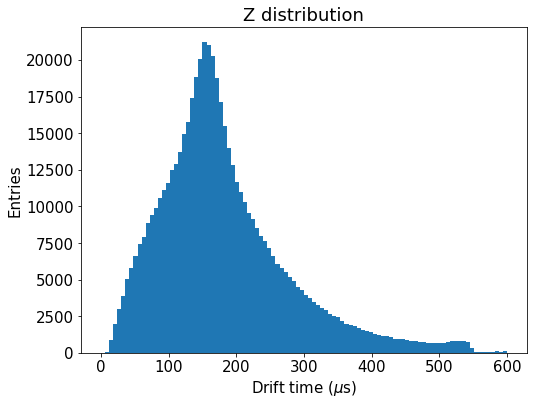

In [7]:
hist(full.Z, 100, Zrange)
labels("Drift time ($\mu$s)", "Entries", "Z distribution")
save("Z")

T1/2 = 4749105203.28 +- inf y


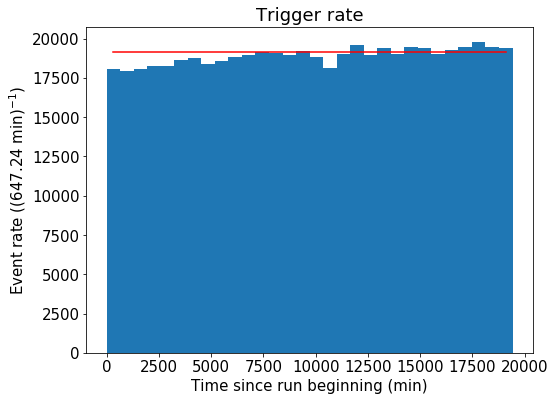

In [8]:
T       = full.time.values / 60
T      -= np.min(T)
 
y, x, _  = hist(T, 30, (np.min(T), np.max(T)))
bin_size = np.diff(x)[0]

sel = y > np.mean(y) - np.std(y)
f = fitf.fit(fitf.expo, x[sel], y[sel], (np.max(y), -1e4), sigma=poisson_sigma(y[sel]))

plt.plot(x, f.fn(x), global_fit_draw_opt)
labels("Time since run beginning (min)",
       "Event rate (({:.2f} min)$^{{-1}}$)".format(bin_size),
       "Trigger rate")
save("EventRate")

scale = np.log(2)*bin_size/60/24/365.25
print("T1/2 = {:.2f} +- {:.2f} y".format(-f.values[1]*scale, f.errors[1]*scale))

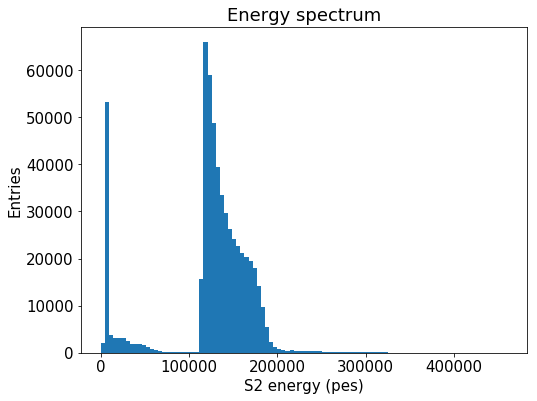

In [9]:
hist(full.S2e, full_range_bins*2)
labels("S2 energy (pes)", "Entries", "Energy spectrum")
save("Raw_energy_wide")

# S2 energy

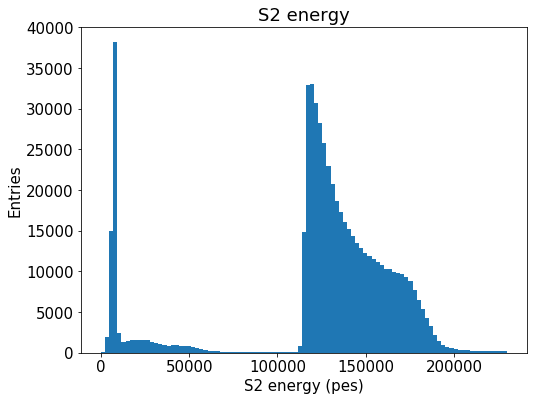

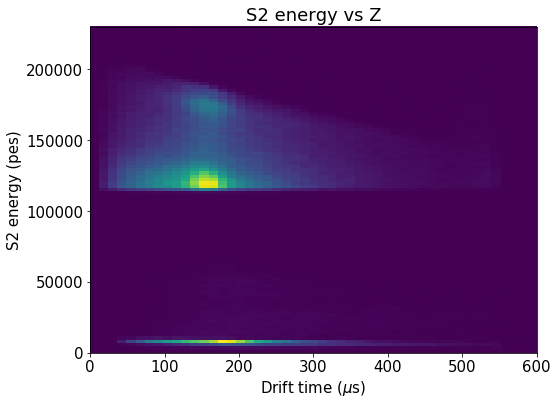

In [10]:
hist(full.S2e, full_range_bins)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("S2energy")


hist2d(full.Z, full.S2e, (Zbins, full_range_bins))
labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 energy vs Z")
save("S2energyvsZ")

# Lifetime calculation

In [11]:
fid = full
fid = fid[fid.R < 100] # Fiducialize in order to reduce geometrical effects
print("Ratio:", len(fid)/len(full))
fid.head()

Ratio: 0.39758465086857775


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.502133e+09,0,1,175.0,16.573950,87.241216,894475.0,11.904375,21740.093750,...,1004237.5,165,109.7625,109.7625,47.603783,77.530381,90.978460,1.020145,31.323017,36.885737
2,3,1.502133e+09,0,1,175.0,26.533182,136.164050,836625.0,24.792500,14396.042969,...,1010537.5,172,173.9125,173.9125,-87.326647,12.513034,88.218588,2.999271,30.138869,28.408456
4,5,1.502133e+09,0,1,150.0,18.638519,89.657207,982125.0,16.535688,20698.324219,...,1012412.5,96,30.2875,30.2875,4.912402,-59.092401,59.296235,-1.487856,21.662886,22.386061
6,7,1.502133e+09,0,1,150.0,23.759180,111.791636,858275.0,15.062062,15361.782227,...,1006337.5,129,148.0625,148.0625,45.266970,13.202136,47.152890,0.283779,26.007818,27.292150
10,11,1.502133e+09,0,1,200.0,24.208588,139.780362,772025.0,19.203187,15166.627930,...,1009887.5,134,237.8625,237.8625,41.703883,39.478386,57.426098,0.757991,24.756790,26.682038


# S2 energy fiducialized

Energy at z=0 = 9128 +- 18
Lifetime      = 1487 +- 20
Chi2          = 0.408541887436


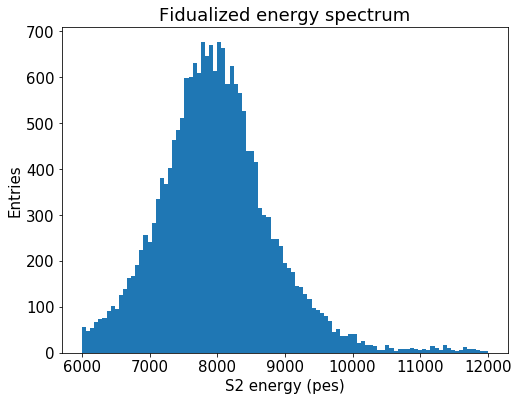

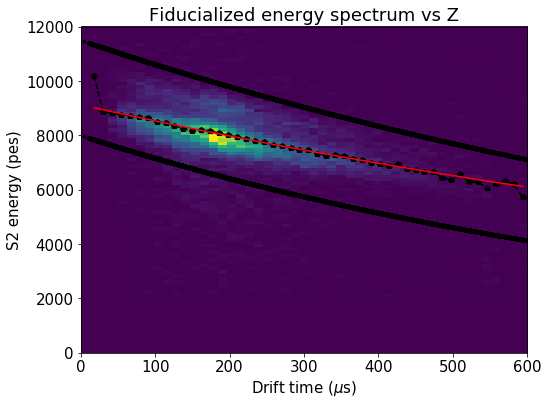

In [12]:
hist(fid.S2e, XR_range_bins)
labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")
save("Raw_energy_fiducial")

low_cut   =  8000 * np.exp(-0.0011*fid.Z.values)
high_cut  = 11500 * np.exp(-0.0008*fid.Z.values)
sel       = coref.in_range(fid.S2e.values, low_cut, high_cut) # remove low and high E background
bins      = np.linspace(0, XR_range[1], XR_range_bins.size)

hist2d(fid.Z, fid.S2e, (Zbins, bins))
x, y, u_y = fitf.profileX(fid.Z[sel], fid.S2e[sel], nZ, xrange=Zrange)

plt.plot(x, y, prof_draw_opt)
plt.plot(fid.Z.values,  low_cut, "k.")
plt.plot(fid.Z.values, high_cut, "k.")

seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

plt.plot(x, f.fn(x), global_fit_draw_opt)
print("Energy at z=0 =", measurement_string( f.values[0], f.errors[0]))
print("Lifetime      =", measurement_string(-f.values[1], f.errors[1]))
print("Chi2          =", f.chi2)

labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
save("Raw_energy_vsZ_fiducial")

LT   = fixed_lifetime        if fixed_lifetime else -f.values[1]
u_LT = fixed_lifetime * 0.01 if fixed_lifetime else  f.errors[1]

Zcorr = corrf.LifetimeCorrection(LT, u_LT)

# Lifetime evolution

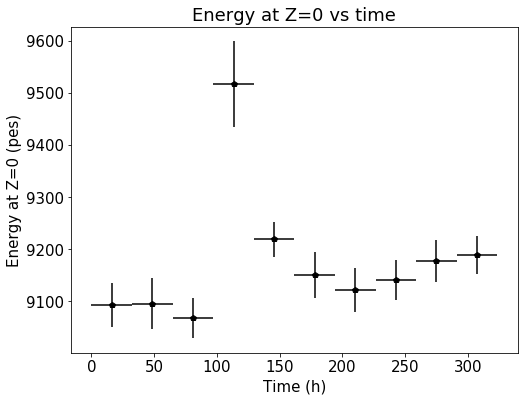

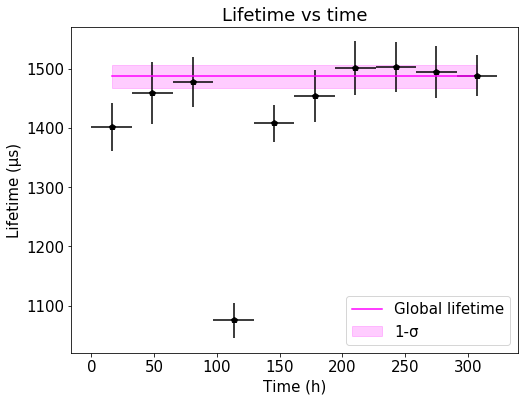

In [13]:
low_cut   =  8000 * np.exp(-0.0011*fid.Z.values)
high_cut  = 11500 * np.exp(-0.0008*fid.Z.values)
sel_E     = coref.in_range(fid.S2e.values, low_cut, high_cut) # remove low and high E background

T     = fid.time.values - full.time.values.min()
Tbins = np.linspace(0, T.max(), nbins_LT + 1)

LTs   = []
u_LTs = []
E0s   = []
u_E0s = []
for i in range(nbins_LT):
    sel_T = coref.in_range(T, *Tbins[i:i+2])
    x, y, u_y = fitf.profileX(fid.Z[sel_E & sel_T], fid.S2e[sel_E & sel_T], nZ, xrange=Zrange)

    seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
    f    = fitf.fit(fitf.expo, x[u_y>0], y[u_y>0], seed, fit_range=Zrange_LT, sigma=u_y[u_y>0])

    E0s  .append( f.values[0])
    u_E0s.append( f.errors[0])
    LTs  .append(-f.values[1])
    u_LTs.append( f.errors[1])

Tbins = shift_to_bin_centers(Tbins)/3600

plt.figure()
plt.errorbar(Tbins, E0s, u_E0s, np.diff(Tbins)[0] * 0.5, data0_draw_opt)
labels("Time (h)", "Energy at Z=0 (pes)", "Energy at Z=0 vs time")
save("E0vsT")

plt.figure()
plt.errorbar    (Tbins, LTs, u_LTs, np.diff(Tbins)[0] * 0.5, data0_draw_opt)
plt.plot        (Tbins, np.full_like(Tbins, LT), color="magenta", label="Global lifetime")
plt.fill_between(Tbins, LT - u_LT, LT + u_LT, alpha=0.2, color="magenta", label="1-σ")
plt.legend()
labels("Time (h)", "Lifetime (µs)", "Lifetime vs time")
save("LifetimevsT")

In [14]:
E_xyzcorr = full.S2e.values * Zcorr(full.Z.values).value * XYcorrection(full.X.values, full.Y.values).value

# Time dependence

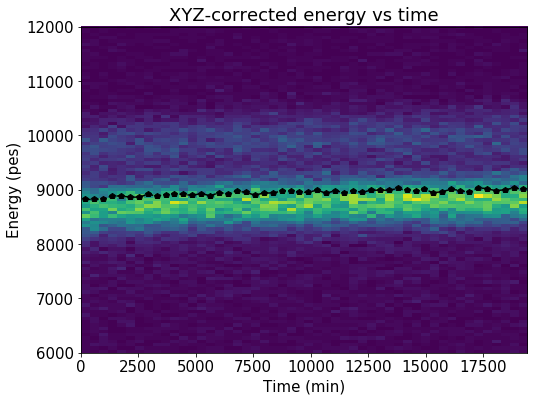

In [15]:
T     = (full.time.values - np.min(full.time.values))/60
nT    = 50
Tbins = np.linspace(0, np.max(T), nT+1)

hist2d(T, E_xyzcorr, (Tbins, XR_range_bins))
x, y, u_y = fitf.profileX(T, E_xyzcorr, nT, yrange=XR_range)
plt.plot(x, y, prof_draw_opt)

labels("Time (min)", "Energy (pes)", "XYZ-corrected energy vs time")
save("EcorrZXYvsT")

Tcorr = corrf.Correction((x,), y, u_y, "max")

In [16]:
T          = (full.time.values - np.min(full.time.values))/60
E_xyztcorr = E_xyzcorr * Tcorr(T).value

# Full spectrum (energy scale from XR)

Peak energy: 657.7 +- 3.9 keV


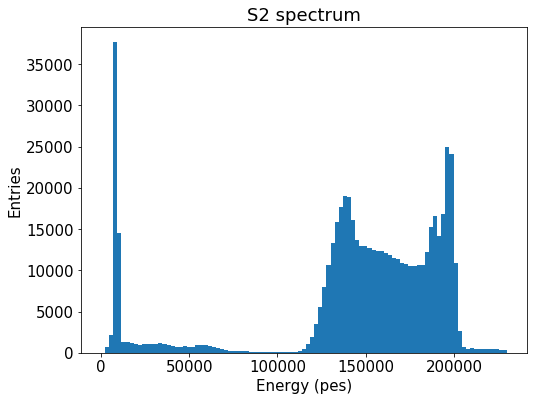

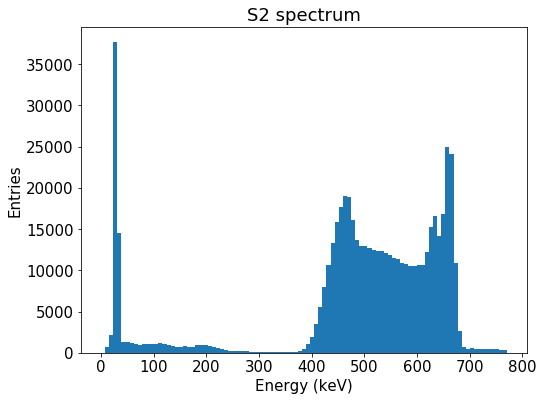

In [17]:
hist(E_xyztcorr, full_range_bins)
labels("Energy (pes)", "Entries", "S2 spectrum")

scale   = 29.6/8835
y, x, _ = hist(E_xyztcorr*scale, full_range_bins * scale)

sel = coref.in_range(x, PP_range[0]*scale, PP_range[1]*scale)
print("Peak energy: {} keV".format(measurement_string(x[sel][np.argmax(y[sel])], np.diff(x)[0]*0.5)))
labels("Energy (keV)", "Entries", "S2 spectrum")

# XR peak

Resolution at 29.7 keV: 7.871 +- 0.064
Resolution at 2458 keV: 0.8652 +- 0.0070
Chi2                  : 1.40031463566


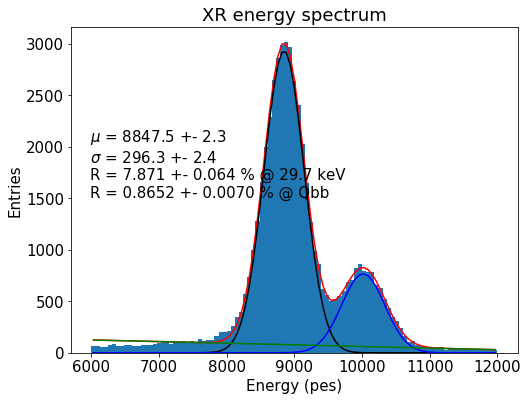

In [18]:
y, x, _ = \
hist(E_xyztcorr, XR_range_bins)

fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                        fitf.gauss  (x, *args[3:6]) + \
                        fitf.polynom(x, *args[6: ])

ndat = np.sum(y)
seed = ndat    , XR1_fit_seed    , XR1_fit_seed*0.03, ndat    , XR2_fit_seed    , XR2_fit_seed*0.03,  np.mean(y)/10, -1e-2
low  = ndat/1e2, XR1_fit_seed*0.9, XR1_fit_seed*0.01, ndat/100, XR2_fit_seed*0.9, XR2_fit_seed*0.01, -np.mean(y)   , -1e+1
upp  = ndat*1e2, XR1_fit_seed*1.1, XR1_fit_seed*0.06, ndat*100, XR2_fit_seed*1.1, XR2_fit_seed*0.06,  np.mean(y)   , +1e+1

f_XR = fitf.fit(fun, x, y, seed, fit_range=XR_fit_range, sigma=poisson_sigma(y), bounds=(low, upp))
assert not np.any(np.isclose(f_XR.values, seed)), np.isclose(f_XR.values, seed)
assert not np.any(np.isclose(f_XR.values, low) ), np.isclose(f_XR.values, low )
assert not np.any(np.isclose(f_XR.values, upp) ), np.isclose(f_XR.values, upp )

plt.plot(x, f_XR.fn     (x                   ), global_fit_draw_opt)
plt.plot(x, fitf.gauss  (x, *f_XR.values[ :3]), peak_1_fit_draw_opt)
plt.plot(x, fitf.gauss  (x, *f_XR.values[3:6]), peak_2_fit_draw_opt)
plt.plot(x, fitf.polynom(x, *f_XR.values[6: ]),    bkg_fit_draw_opt)
plt.text(plt.xlim()[0] * 1.05, np.max(y)/2,
         gausstext(f_XR.values, f_XR.errors, XR1_energy_keV))

reso_XR = resolution(f_XR.values, f_XR.errors, XR1_energy_keV)
print(resolution_at_xr_string , measurement_string(*reso_XR[0]))
print(resolution_at_qbb_string, measurement_string(*reso_XR[1]))
print(             chi2_string, f.chi2)

plt.ylim(0)
labels("Energy (pes)", "Entries", "XR energy spectrum")

# Photopeak

Resolution at 662  keV: 2.819 +- 0.021
Resolution at 2458 keV: 1.463 +- 0.011
Chi2                  : 1.40031463566


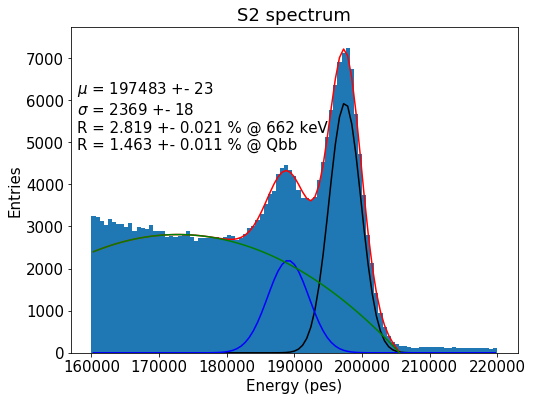

In [19]:
y, x, _ = \
hist(E_xyztcorr, PP_range_bins)

fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                        fitf.gauss  (x, *args[3:6]) + \
                        fitf.polynom(x, *args[6: ])

ndat = np.sum(y)
seed = ndat*1e2, PP1_fit_seed     , PP1_fit_seed*0.010, ndat*2e1, PP2_fit_seed     , PP2_fit_seed*0.010,  2e3, 1e-2, -1e-7
low  = ndat    , PP1_fit_seed*0.99, PP1_fit_seed*0.003, ndat    , PP2_fit_seed*0.99, PP2_fit_seed*0.003, -1e5,-1e+3, -1e-1
upp  = ndat*1e4, PP1_fit_seed*1.01, PP1_fit_seed*0.020, ndat*1e3, PP2_fit_seed*1.01, PP2_fit_seed*0.030,  1e5, 1e+3, +1e-5

f_PP = fitf.fit(fun, x, y, seed, fit_range=PP_fit_range, sigma=poisson_sigma(y), bounds=(low, upp))

assert not np.any(np.isclose(f_PP.values, seed)), np.isclose(f_PP.values, seed)
assert not np.any(np.isclose(f_PP.values, low) ), np.isclose(f_PP.values, low )
assert not np.any(np.isclose(f_PP.values, upp) ), np.isclose(f_PP.values, upp )

plt.plot(x, f_PP.fn     (x                   ), global_fit_draw_opt)
plt.plot(x, fitf.gauss  (x, *f_PP.values[ :3]), peak_1_fit_draw_opt)
plt.plot(x, fitf.gauss  (x, *f_PP.values[3:6]), peak_2_fit_draw_opt)
plt.plot(x, fitf.polynom(x, *f_PP.values[6: ]),    bkg_fit_draw_opt)
plt.text(plt.xlim()[0] * 1.005, np.max(y)/1.5,
         gausstext(f_PP.values, f_PP.errors, PP1_energy_keV))

reso_PP = resolution(f_PP.values, f_PP.errors, PP1_energy_keV)
print(resolution_at_pp_string , measurement_string(*reso_PP[0]))
print(resolution_at_qbb_string, measurement_string(*reso_PP[1]))
print(             chi2_string, f.chi2)

plt.ylim(0)
labels("Energy (pes)", "Entries", "S2 spectrum")

# Fiducialized photopeak

Resolution at 662  keV: 2.387 +- 0.023
Resolution at 2458 keV: 1.239 +- 0.012
Chi2                  : 1.88959230754


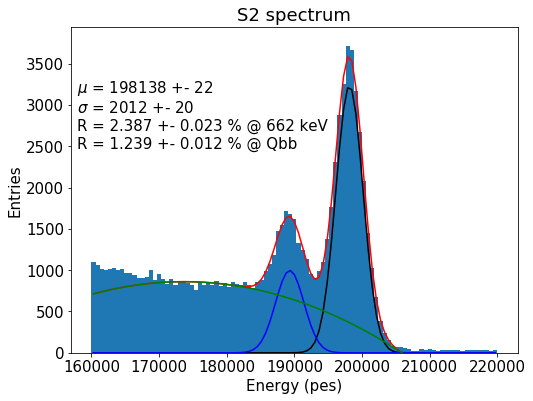

In [20]:
y, x, _ = \
hist(E_xyztcorr[full.R.values < 100], PP_range_bins)

fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                        fitf.gauss  (x, *args[3:6]) + \
                        fitf.polynom(x, *args[6: ])

ndat = np.sum(y)
seed = ndat*1e2, PP1_fit_seed     , PP1_fit_seed*0.010, ndat*2e1, PP2_fit_seed     , PP2_fit_seed*0.010,  2e3, 1e-2, -1e-7
low  = ndat    , PP1_fit_seed*0.99, PP1_fit_seed*0.003, ndat    , PP2_fit_seed*0.99, PP2_fit_seed*0.003, -1e5,-1e+3, -1e-1
upp  = ndat*1e4, PP1_fit_seed*1.01, PP1_fit_seed*0.020, ndat*1e3, PP2_fit_seed*1.01, PP2_fit_seed*0.030,  1e5, 1e+3, +1e-5

f = fitf.fit(fun, x, y, seed, fit_range=PP_fit_range, sigma=poisson_sigma(y), bounds=(low, upp))

assert not np.any(np.isclose(f.values, seed)), np.isclose(f.values, seed)
assert not np.any(np.isclose(f.values, low) ), np.isclose(f.values, low )
assert not np.any(np.isclose(f.values, upp) ), np.isclose(f.values, upp )

plt.plot(x, f   .fn     (x                ), global_fit_draw_opt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), peak_1_fit_draw_opt)
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), peak_2_fit_draw_opt)
plt.plot(x, fitf.polynom(x, *f.values[6: ]),    bkg_fit_draw_opt)
plt.text(plt.xlim()[0] * 1.005, np.max(y)/1.5,
         gausstext(f.values, f.errors, PP1_energy_keV))

reso = resolution(f.values, f.errors, PP1_energy_keV)
print(resolution_at_pp_string , measurement_string(*reso[0]))
print(resolution_at_qbb_string, measurement_string(*reso[1]))
print(             chi2_string, f.chi2)

plt.ylim(0)
labels("Energy (pes)", "Entries", "S2 spectrum")

# Regions of interest

In [21]:
XRsel = coref.in_range(E_xyztcorr, f_XR.values[1] - 2*f_XR.values[2], f_XR.values[1] + 2*f_XR.values[2])
XR    = full[XRsel]
PPsel = coref.in_range(E_xyztcorr, f_PP.values[1] - 2*f_PP.values[2], f_PP.values[1] + 2*f_PP.values[2])
PP    = full[PPsel]

print("# events in photopeak:", np.count_nonzero(XRsel))
print("# events in XR       :", np.count_nonzero(PPsel))

# events in photopeak: 36238
# events in XR       : 77555


# Spatial distributions

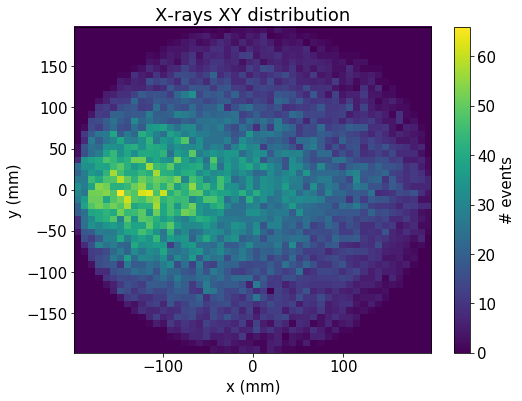

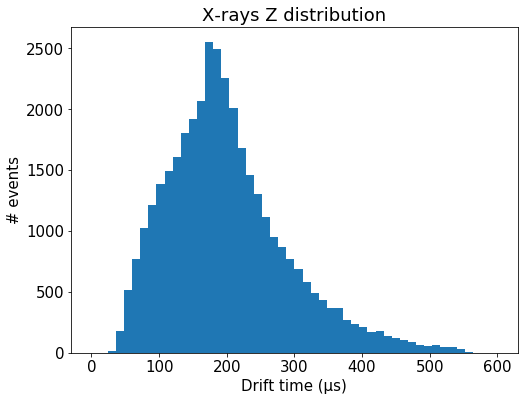

In [22]:
hist2d(XR.X.values, XR.Y.values, (nX, nY), (XYrange, XYrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)", "X-rays XY distribution")

hist(XR.Z.values, nZ, (Zrange))
labels("Drift time (µs)", "# events", "X-rays Z distribution")

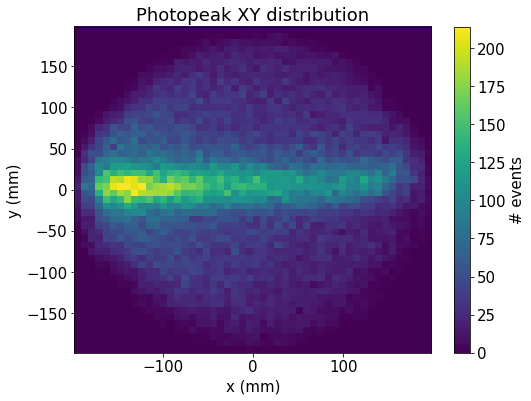

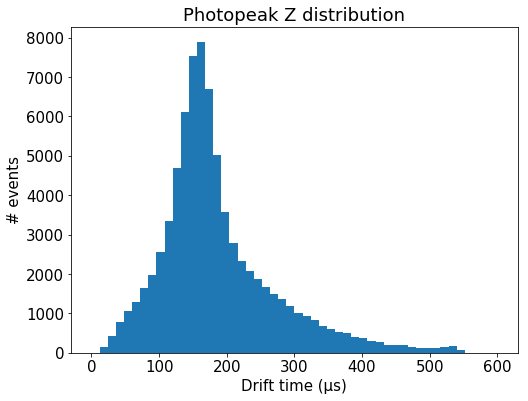

In [23]:
hist2d(PP.X.values, PP.Y.values, (nX, nY), (XYrange, XYrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)", "Photopeak XY distribution")

hist(PP.Z.values, nZ, (Zrange))
labels("Drift time (µs)", "# events", "Photopeak Z distribution")

# X-rays

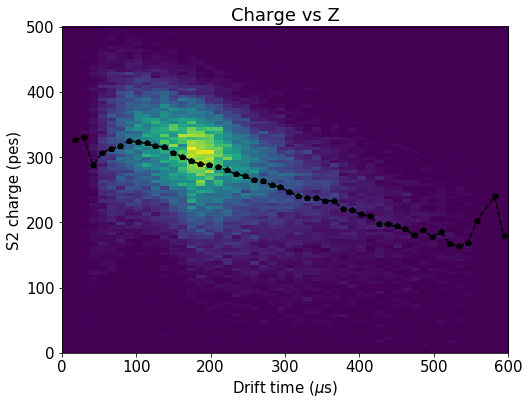

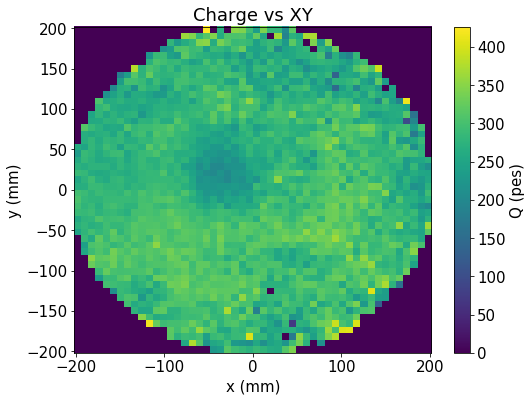

In [24]:
hist2d(XR.Z, XR.S2q, (nZ, 100), range=(Zrange, Qrange))
x, y, _ = fitf.profileX(XR.Z, XR.S2q, nZ, xrange=Zrange, yrange=Qrange)
plt.plot(x, y, prof_draw_opt)

labels("Drift time ($\mu$s)", "S2 charge (pes)", "Charge vs Z")
save("QvsZ")

x, y, Q, u_Q = \
fitf.profileXY(XR.X, XR.Y, XR.S2q, nX, nY, XYrange, XYrange)
_, cb = display_matrix(x, y, Q)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)", "Charge vs XY")
save("QvsXY")

Reference energy = 8891.627095372107 pes


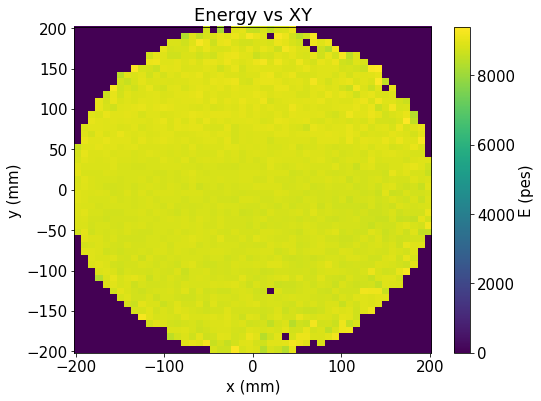

In [25]:
xc, yc, Ec, u_Ec = \
fitf.profileXY(XR.X.values, XR.Y.values, E_xyztcorr[XRsel], nX, nY, XYrange, XYrange)
_, cb = display_matrix(xc, yc, Ec)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)", "Energy vs XY")
save("EvsXY")

XYcorrection_XR = corrf.Correction((xc, yc), Ec, u_Ec, "index", index=(nX//2, nY//2))
print("Reference energy = {} pes".format(Ec[tuple(np.argwhere(XYcorrection_XR._fs==1)[0])]))

# Correction map

In [26]:
XR_map_pitch = np.diff(np.linspace(*XYrange, nX+1))[0]
XYcorrection_Kr_same_pitch = dstf.load_xy_corrections(correction_filename.format(XR_map_pitch))

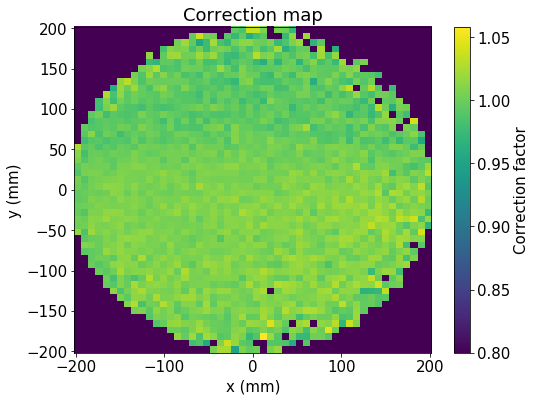

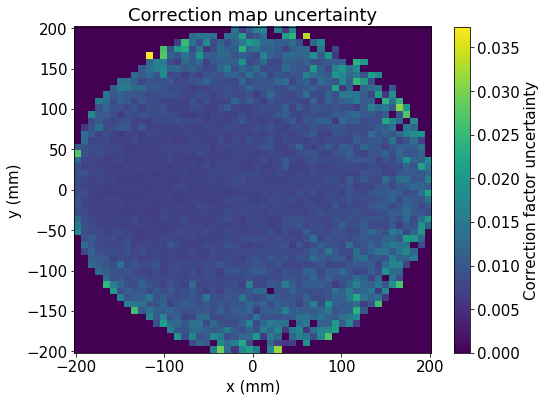

In [27]:
_r = (np.repeat(xc, yc.size)**2 +
      np.tile  (yc, xc.size)**2)**0.5
_f = XYcorrection_XR._fs.flatten()
_u = XYcorrection_XR._us.flatten()

_, cb = display_matrix(xc, yc, _f, vmin=0.8)
labels("x (mm)", "y (mm)", "Correction map")
cb.set_label("Correction factor")
save("CorrectionMap")

_, cb = display_matrix(xc, yc, _u)
labels("x (mm)", "y (mm)", "Correction map uncertainty")
cb.set_label("Correction factor uncertainty")
save("CorrectionMapUncertainty")

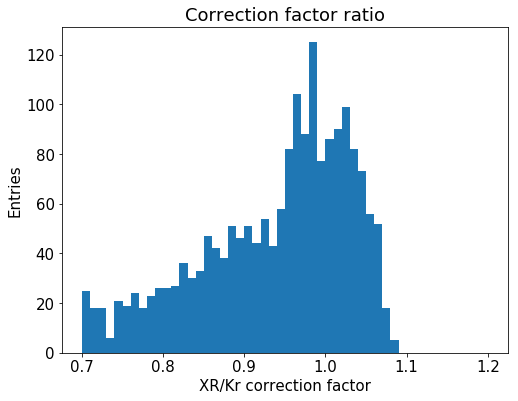

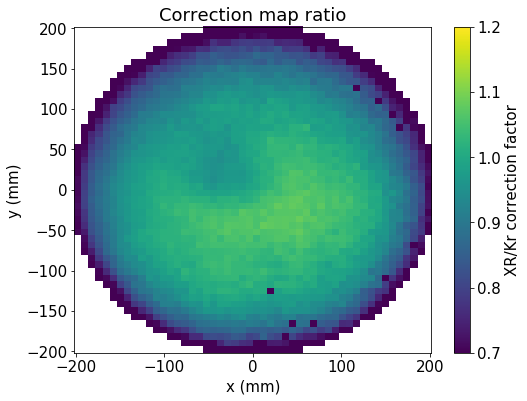

In [28]:
ratio = XYcorrection_XR._fs / XYcorrection_Kr_same_pitch._fs

y, x, _ = \
hist(ratio.flatten(), 50, (0.7, 1.2))
labels("XR/Kr correction factor", "Entries", "Correction factor ratio")

#f = fitf.fit(fitf.gauss, x, y, (1e3, 1, 0.1))
#plt.plot(x, f.fn(x), global_fit_draw_opt)
#plt.text(plt.xlim()[0] * 1.01, plt.ylim()[1]/2,
#         "µ = {}\nσ = {}".format(measurement_string(f.values[1], f.errors[1]),
#                                 measurement_string(f.values[2], f.errors[2])))
save("CorrectionMapRatio")

_, cb = display_matrix(xc, yc, ratio, vmin=0.7, vmax=1.2)
labels("x (mm)", "y (mm)", "Correction map ratio")
cb.set_label("XR/Kr correction factor")
save("CorrectionMapRatio_XY")

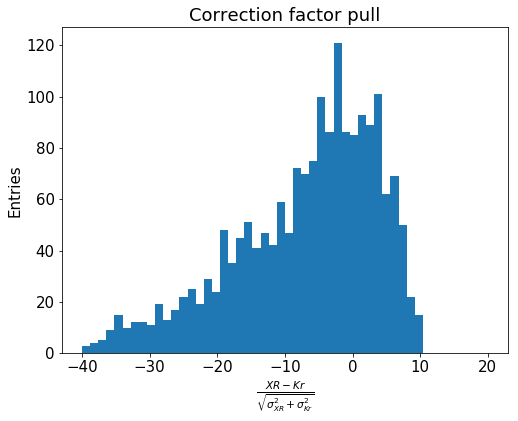

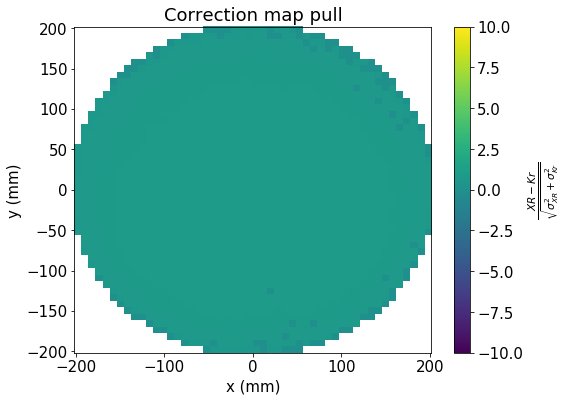

In [29]:
pull = (XYcorrection_XR._fs - XYcorrection_Kr_same_pitch._fs) / (XYcorrection_XR._us**2 - XYcorrection_Kr_same_pitch._us**2)**0.5

y, x, _ = \
hist(pull.flatten(), 50, (-40, 20))
labels(r"$\frac{XR - Kr}{\sqrt{\sigma_{XR}^2 + \sigma_{Kr}^2}}$", "Entries", "Correction factor pull")

#f = fitf.fit(fitf.gauss, x, y, (1e3, 1, 0.1))
#plt.plot(x, f.fn(x), global_fit_draw_opt)
#plt.text(plt.xlim()[0] * 0.99, plt.ylim()[1]/2,
#         "µ = {}\nσ = {}".format(measurement_string(f.values[1], f.errors[1]),
#                                 measurement_string(f.values[2], f.errors[2])))
save("CorrectionMapPull")

_, cb = display_matrix(xc, yc, ratio, vmin=-10, vmax=10)
labels("x (mm)", "y (mm)", "Correction map pull")
cb.set_label(r"$\frac{XR - Kr}{\sqrt{\sigma_{XR}^2 + \sigma_{Kr}^2}}$")
save("CorrectionMapPull_XY")

# Resolution dependences

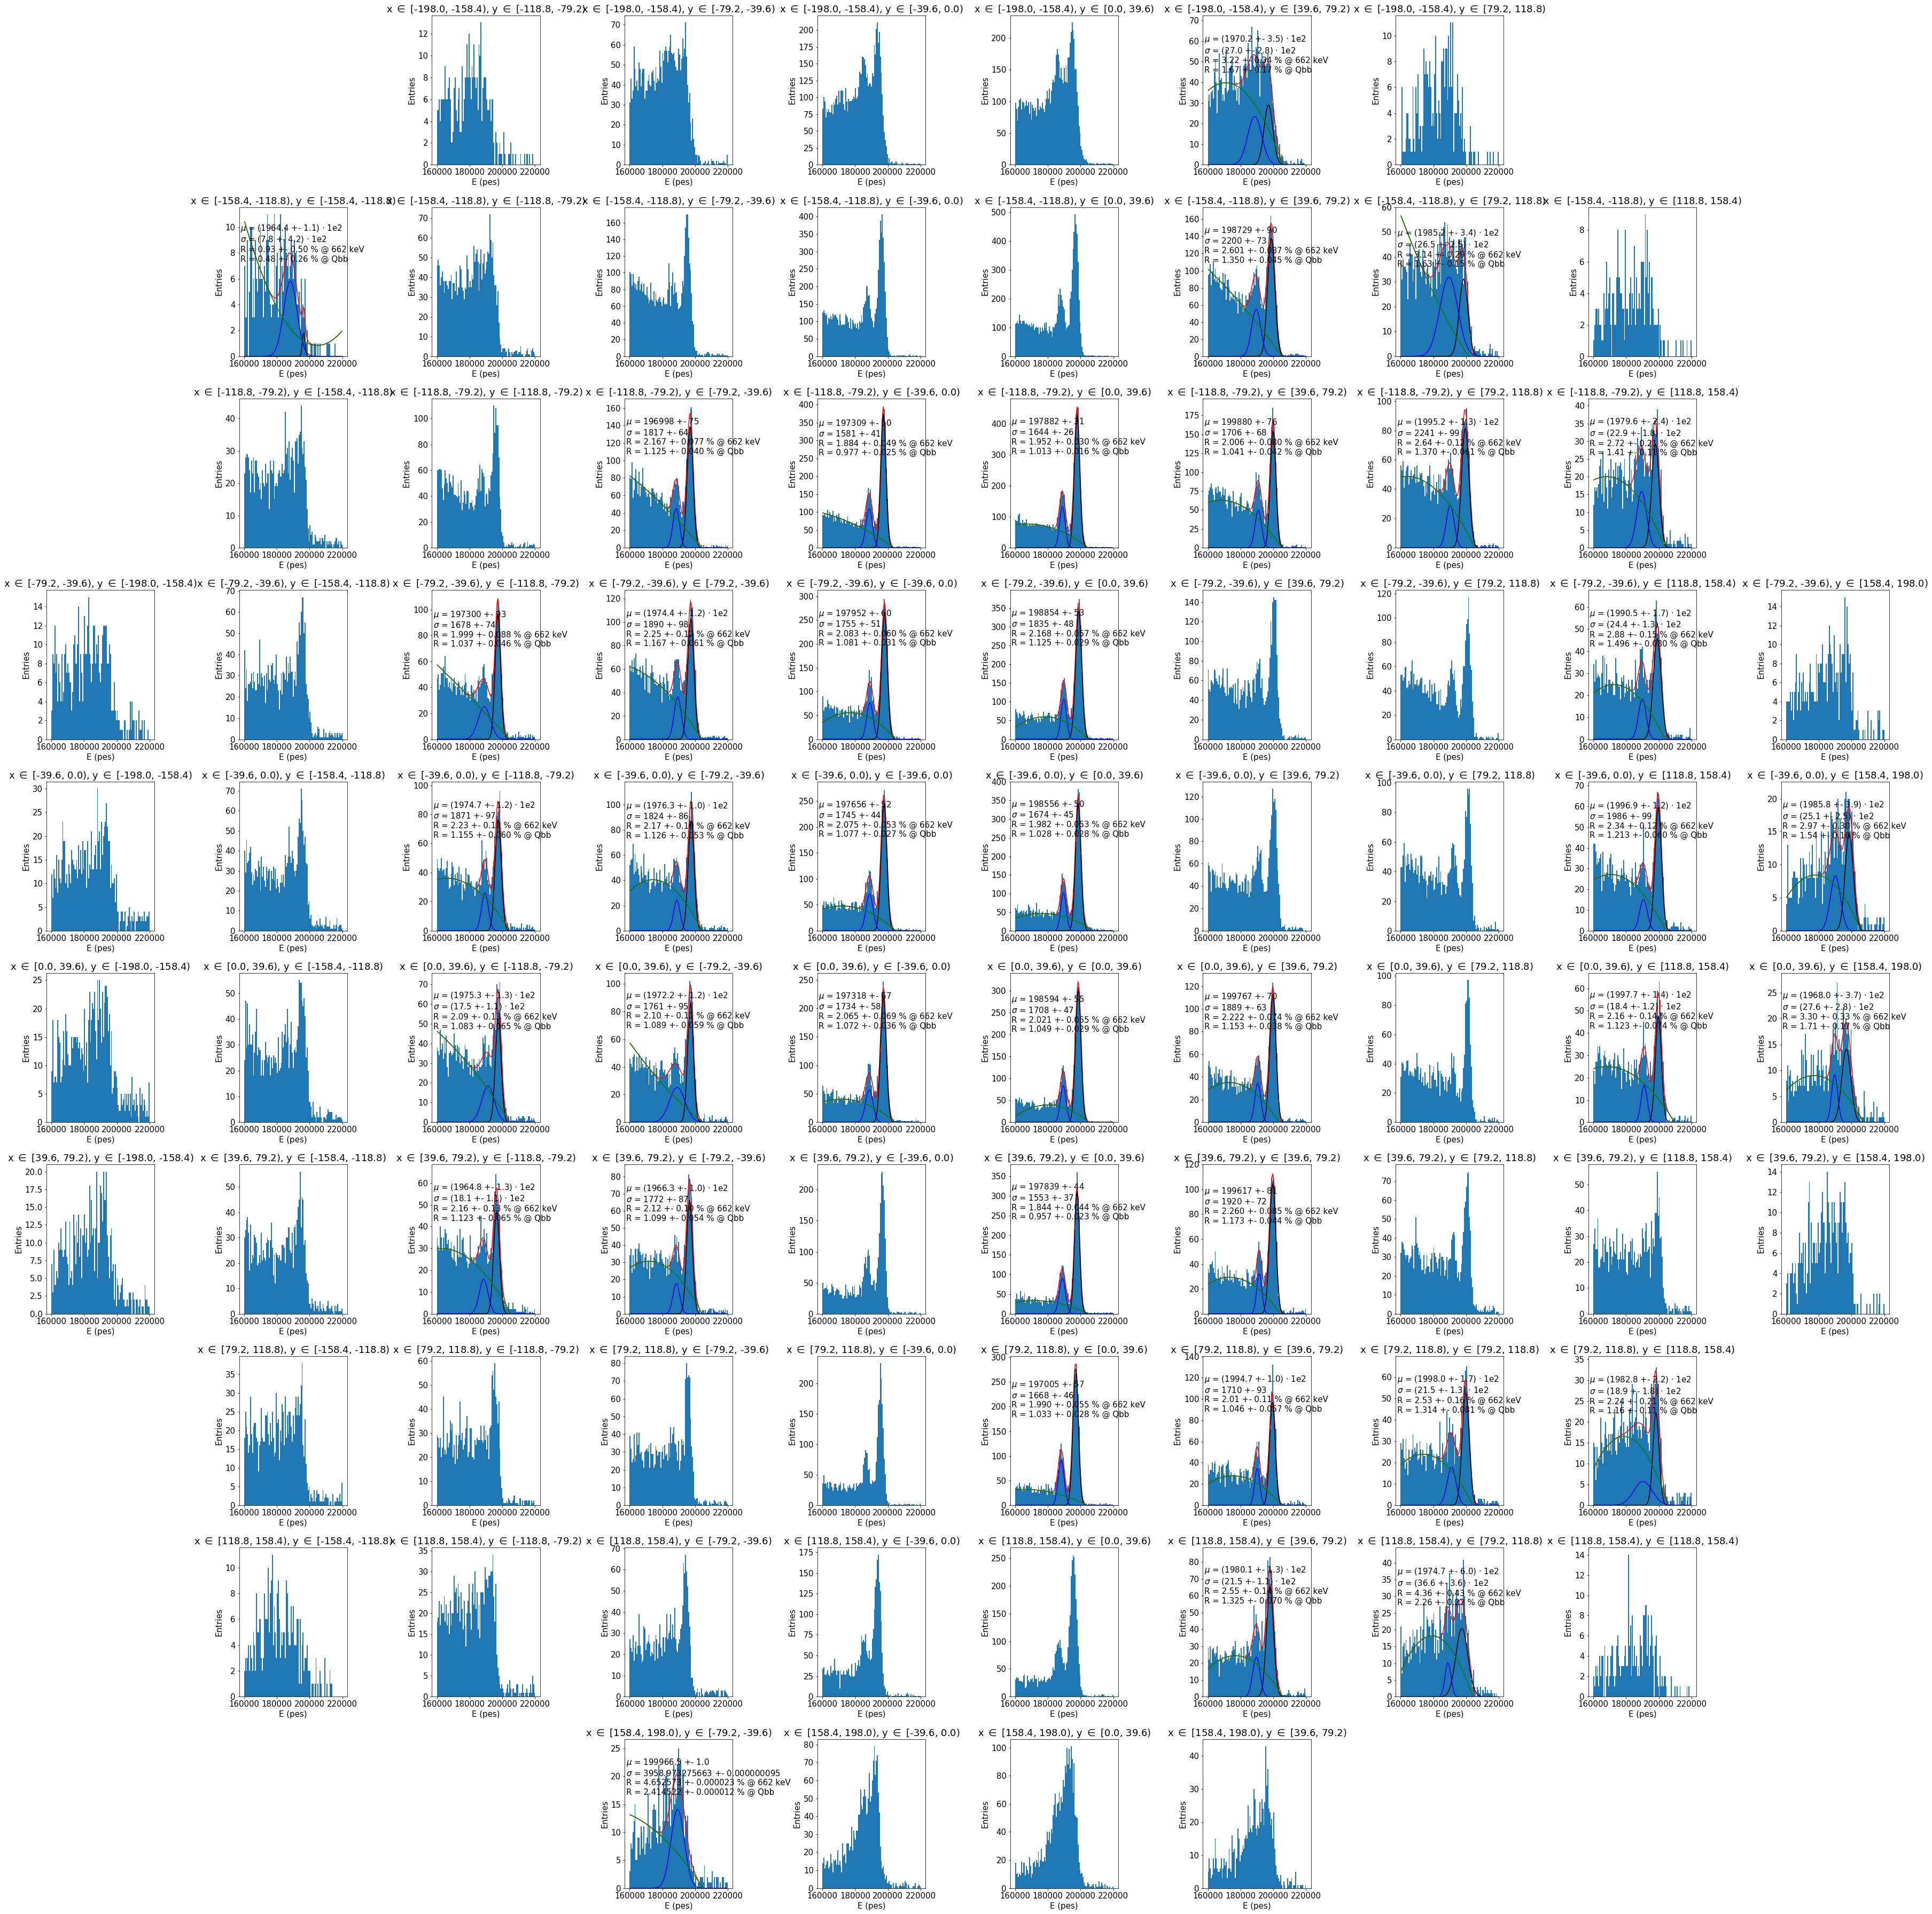

In [30]:
nx, ny = 10, 10
xbins  = np.linspace(*XYrange, nx+1)
ybins  = np.linspace(*XYrange, ny+1)

fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                        fitf.gauss  (x, *args[3:6]) + \
                        fitf.polynom(x, *args[6: ])

ndat = len(PP)
seed = ndat    , PP1_fit_seed     , PP1_fit_seed*0.010, ndat    , PP2_fit_seed     , PP2_fit_seed*0.010,  2e3, 1e-2, -1e-7
low  = ndat*  0, PP1_fit_seed*0.99, PP1_fit_seed*0.003, ndat*  0, PP2_fit_seed*0.99, PP2_fit_seed*0.003, -1e5,-1e+3, -1e-1
upp  = ndat*1e8, PP1_fit_seed*1.01, PP1_fit_seed*0.020, ndat*1e8, PP2_fit_seed*1.01, PP2_fit_seed*0.030,  1e5, 1e+3, +1e-5

R_values   = np.zeros((nx, ny))
u_R_values = np.zeros_like(R_values) 

plt.figure(figsize=(5*nx, 5*ny))
for i in range(nx):
    for j in range(ny):
        sel = coref.in_range(full.X.values, *xbins[i:i+2]) &\
              coref.in_range(full.Y.values, *ybins[j:j+2]) &\
              coref.in_range(E_xyztcorr   , *PP_range    )
        if np.count_nonzero(sel) < 200:
            continue
        try:
            plt.subplot(nx, ny, i*ny + j + 1)

            E       = E_xyztcorr[sel]
            y, x, _ = hist(E, PP_range_bins, new_figure=False)
            title   = "x $\in$ [{:.1f}, {:.1f}), y $\in$ [{:.1f}, {:.1f})".format(*xbins[i:i+2],
                                                                                  *ybins[j:j+2])
            labels("E (pes)", "Entries", title)

            f = fitf.fit(fun, x, y, seed, fit_range=PP_fit_range, sigma=poisson_sigma(y), bounds=(low, upp))

            assert not np.any(np.isclose(f.values, seed)), np.isclose(f.values, seed)
            assert not np.any(np.isclose(f.values, low) ), np.isclose(f.values, low )
            assert not np.any(np.isclose(f.values, upp) ), np.isclose(f.values, upp )

            plt.plot(x, f   .fn     (x                ), global_fit_draw_opt)
            plt.plot(x, fitf.gauss  (x, *f.values[ :3]), peak_1_fit_draw_opt)
            plt.plot(x, fitf.gauss  (x, *f.values[3:6]), peak_2_fit_draw_opt)
            plt.plot(x, fitf.polynom(x, *f.values[6: ]),    bkg_fit_draw_opt)
            plt.text(plt.xlim()[0] * 1.005, np.max(y)/1.5,
                     gausstext(f.values, f.errors, PP1_energy_keV))
            plt.ylim(0)

            reso             = resolution(f.values, f.errors, PP1_energy_keV)
            R_values  [i, j] = reso[1].value
            u_R_values[i, j] = reso[1].uncertainty
        except:
            continue
plt.tight_layout()

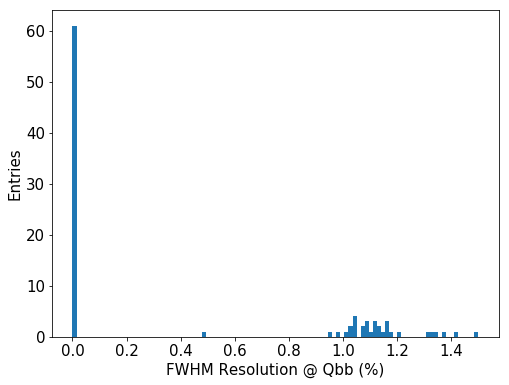

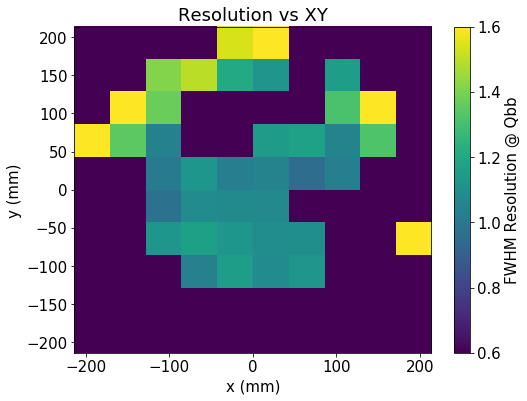

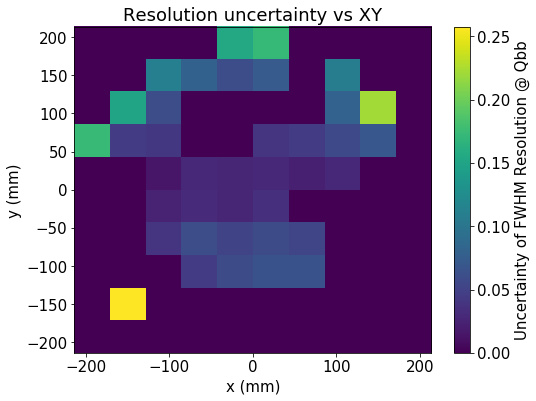

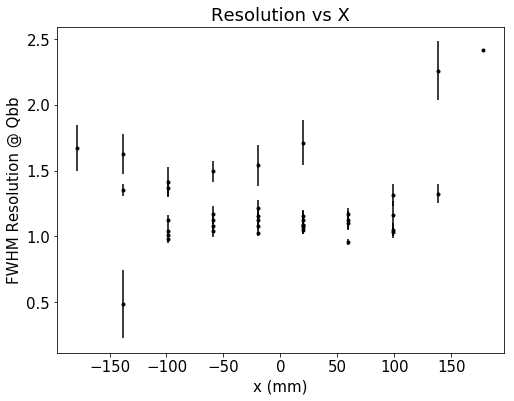

In [31]:
_x = shift_to_bin_centers(xbins)
_y = shift_to_bin_centers(ybins)

hist(R_values.flatten(), 100, (0, 1.5))
labels("FWHM Resolution @ Qbb (%)", "Entries")

_, cb = display_matrix(_x, _y,   R_values, vmin=0.6, vmax=1.6)
cb.set_label("FWHM Resolution @ Qbb")
labels("x (mm)", "y (mm)", "Resolution vs XY")

_, cb = display_matrix(_x, _y, u_R_values)
cb.set_label("Uncertainty of FWHM Resolution @ Qbb")
labels("x (mm)", "y (mm)", "Resolution uncertainty vs XY")

plt.figure()
sel = R_values.flatten() > 0
plt.errorbar(np.repeat(_x, ny)[sel], R_values.flatten()[sel], u_R_values.flatten()[sel], fmt="k.")
labels("x (mm)", "FWHM Resolution @ Qbb", "Resolution vs X")

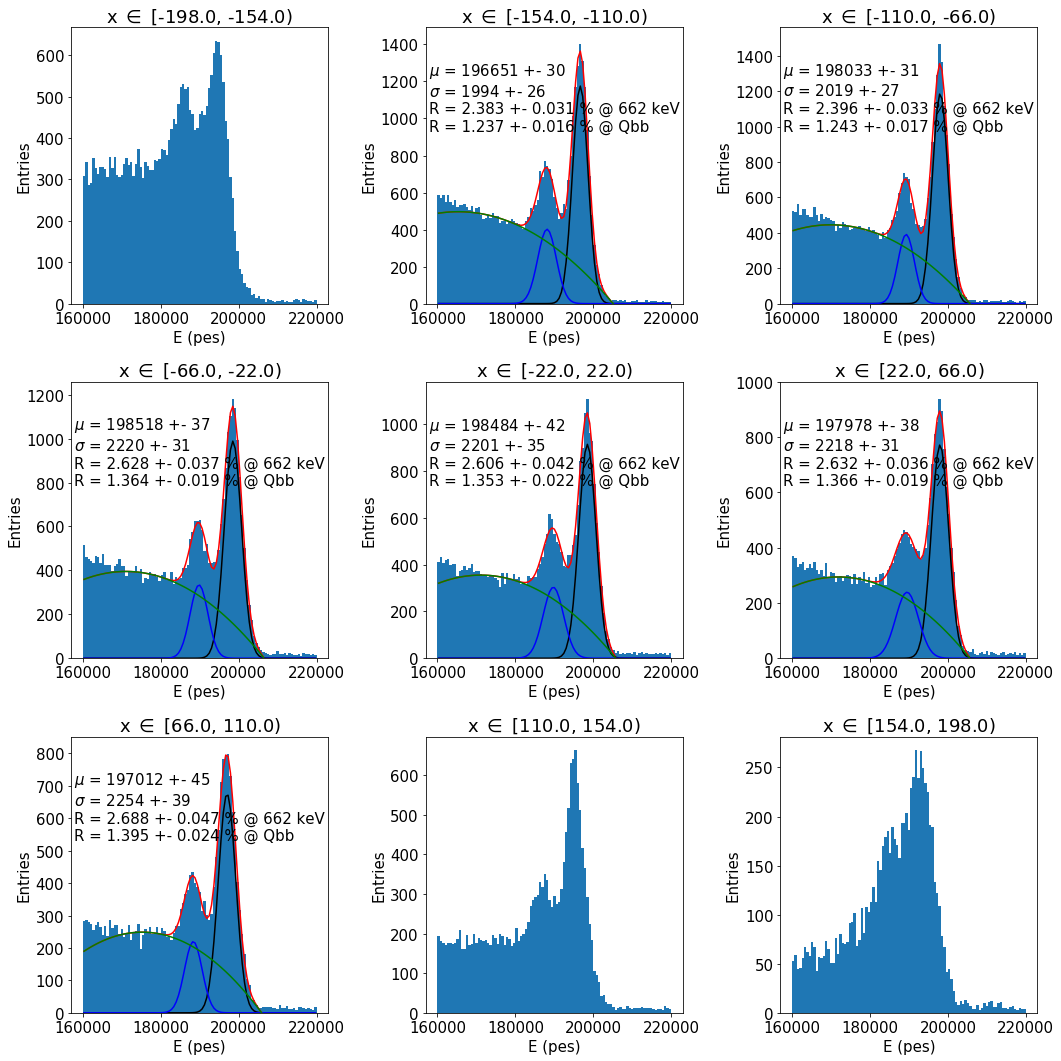

In [32]:
nx     = 9
xbins  = np.linspace(*XYrange, nx+1)

fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                        fitf.gauss  (x, *args[3:6]) + \
                        fitf.polynom(x, *args[6: ])

ndat = len(PP)
seed = ndat    , PP1_fit_seed     , PP1_fit_seed*0.010, ndat    , PP2_fit_seed     , PP2_fit_seed*0.010,  2e3, 1e-2, -1e-7
low  = ndat*  0, PP1_fit_seed*0.99, PP1_fit_seed*0.003, ndat*  0, PP2_fit_seed*0.99, PP2_fit_seed*0.003, -1e5,-1e+3, -1e-1
upp  = ndat*1e8, PP1_fit_seed*1.01, PP1_fit_seed*0.020, ndat*1e8, PP2_fit_seed*1.01, PP2_fit_seed*0.030,  1e5, 1e+3, +1e-5

R_values   = np.zeros(nx)
u_R_values = np.zeros_like(R_values) 

plt.figure(figsize=(5*nx**0.5, 5*nx**0.5))
for i in range(nx):
    plt.subplot(nx//int(nx**0.5), nx//int(nx**0.5), i + 1)

    sel = coref.in_range(full.X.values, *xbins[i:i+2]) &\
          coref.in_range(E_xyztcorr   , *PP_range    )
    if np.count_nonzero(sel) < 200:
        continue

    try:
        E       = E_xyztcorr[sel]
        y, x, _ = hist(E, PP_range_bins, new_figure=False)
        title   = "x $\in$ [{:.1f}, {:.1f})".format(*xbins[i:i+2])
        labels("E (pes)", "Entries", title)

        f = fitf.fit(fun, x, y, seed, fit_range=PP_fit_range, sigma=poisson_sigma(y), bounds=(low, upp), maxfev=10000)

        assert not np.any(np.isclose(f.values, seed)), np.isclose(f.values, seed)
        assert not np.any(np.isclose(f.values, low) ), np.isclose(f.values, low )
        assert not np.any(np.isclose(f.values, upp) ), np.isclose(f.values, upp )

        plt.plot(x, f   .fn     (x                ), global_fit_draw_opt)
        plt.plot(x, fitf.gauss  (x, *f.values[ :3]), peak_1_fit_draw_opt)
        plt.plot(x, fitf.gauss  (x, *f.values[3:6]), peak_2_fit_draw_opt)
        plt.plot(x, fitf.polynom(x, *f.values[6: ]),    bkg_fit_draw_opt)
        plt.text(plt.xlim()[0] * 1.005, np.max(y)/1.5,
                 gausstext(f.values, f.errors, PP1_energy_keV))
        plt.ylim(0)

        res, res_bb   = resolution(f.values, f.errors, PP1_energy_keV)
        R_values  [i] = res_bb.value
        u_R_values[i] = res_bb.uncertainty
    except:
        continue
plt.tight_layout()

[ 0.          1.23662258  1.24341774  1.36377042  1.35262683  1.36605573
  1.39516225  0.          0.        ]


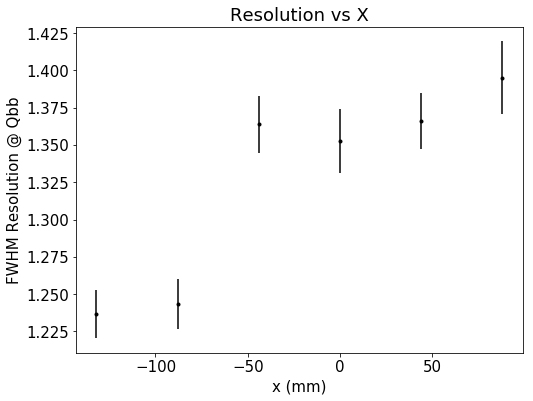

In [33]:
_x = shift_to_bin_centers(xbins)

sel = R_values > 0
print(R_values)

plt.errorbar(_x[sel], R_values[sel], u_R_values[sel], fmt="k.")
labels("x (mm)", "FWHM Resolution @ Qbb", "Resolution vs X")

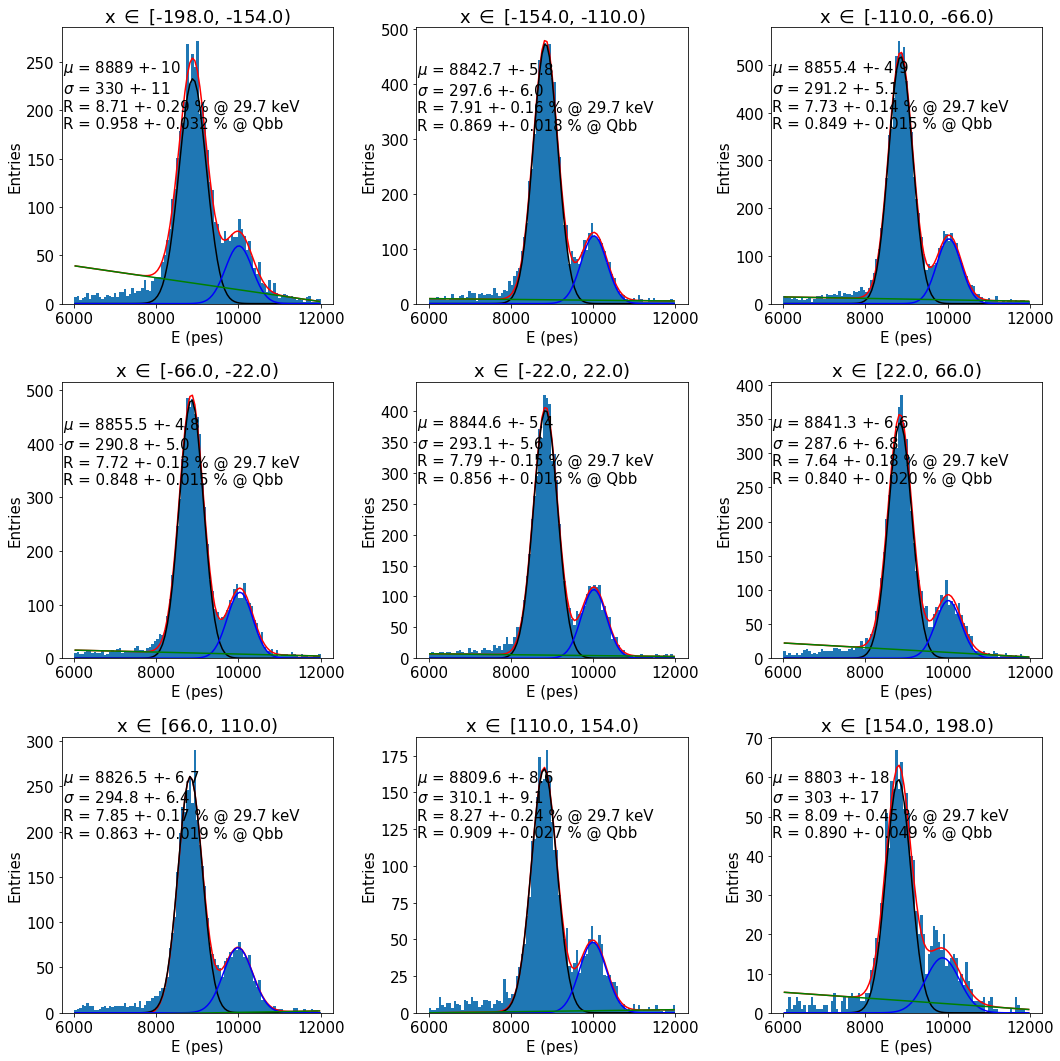

In [34]:
nx     = 9
xbins  = np.linspace(*XYrange, nx+1)

fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                        fitf.gauss  (x, *args[3:6]) + \
                        fitf.polynom(x, *args[6: ])

ndat = len(PP)
seed = ndat    , XR1_fit_seed    , XR1_fit_seed*0.03, ndat    , XR2_fit_seed    , XR2_fit_seed*0.03,  np.mean(y)/10, -1e-2
low  = ndat/1e2, XR1_fit_seed*0.9, XR1_fit_seed*0.01, ndat/100, XR2_fit_seed*0.9, XR2_fit_seed*0.01, -np.mean(y)   , -1e+1
upp  = ndat*1e2, XR1_fit_seed*1.1, XR1_fit_seed*0.06, ndat*100, XR2_fit_seed*1.1, XR2_fit_seed*0.06,  np.mean(y)   , +1e+1

R_values   = np.zeros(nx)
u_R_values = np.zeros_like(R_values) 

plt.figure(figsize=(5*nx**0.5, 5*nx**0.5))
for i in range(nx):
    plt.subplot(nx//int(nx**0.5), nx//int(nx**0.5), i + 1)

    sel = coref.in_range(full.X.values, *xbins[i:i+2]) &\
          coref.in_range(E_xyztcorr   , *XR_range    )
    if np.count_nonzero(sel) < 200:
        continue

    try:
        E       = E_xyztcorr[sel]
        y, x, _ = hist(E, XR_range_bins, new_figure=False)
        title   = "x $\in$ [{:.1f}, {:.1f})".format(*xbins[i:i+2])
        labels("E (pes)", "Entries", title)

        f = fitf.fit(fun, x, y, seed, fit_range=XR_fit_range, sigma=poisson_sigma(y), bounds=(low, upp), maxfev=10000)

        assert not np.any(np.isclose(f.values, seed)), np.isclose(f.values, seed)
        assert not np.any(np.isclose(f.values, low) ), np.isclose(f.values, low )
        assert not np.any(np.isclose(f.values, upp) ), np.isclose(f.values, upp )

        plt.plot(x, f   .fn     (x                ), global_fit_draw_opt)
        plt.plot(x, fitf.gauss  (x, *f.values[ :3]), peak_1_fit_draw_opt)
        plt.plot(x, fitf.gauss  (x, *f.values[3:6]), peak_2_fit_draw_opt)
        plt.plot(x, fitf.polynom(x, *f.values[6: ]),    bkg_fit_draw_opt)
        plt.text(plt.xlim()[0] * 1.005, np.max(y)/1.5,
                 gausstext(f.values, f.errors, XR1_energy_keV))
        plt.ylim(0)

        res, res_bb   = resolution(f.values, f.errors, XR1_energy_keV)
        R_values  [i] = res_bb.value
        u_R_values[i] = res_bb.uncertainty
    except:
        continue
plt.tight_layout()

[ 0.95778856  0.86945336  0.84933935  0.8482008   0.85601618  0.84024095
  0.86271548  0.90922037  0.88968498]


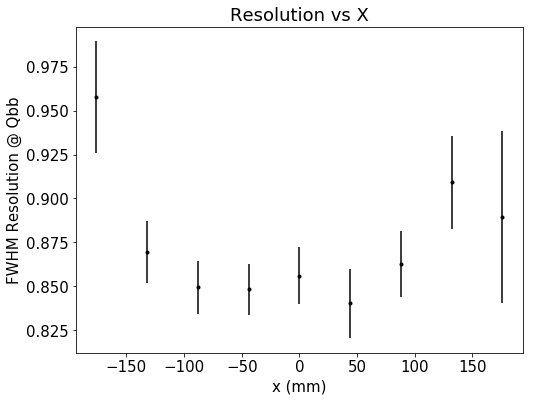

In [35]:
_x = shift_to_bin_centers(xbins)

sel = R_values > 0
print(R_values)

plt.errorbar(_x[sel], R_values[sel], u_R_values[sel], fmt="k.")
labels("x (mm)", "FWHM Resolution @ Qbb", "Resolution vs X")

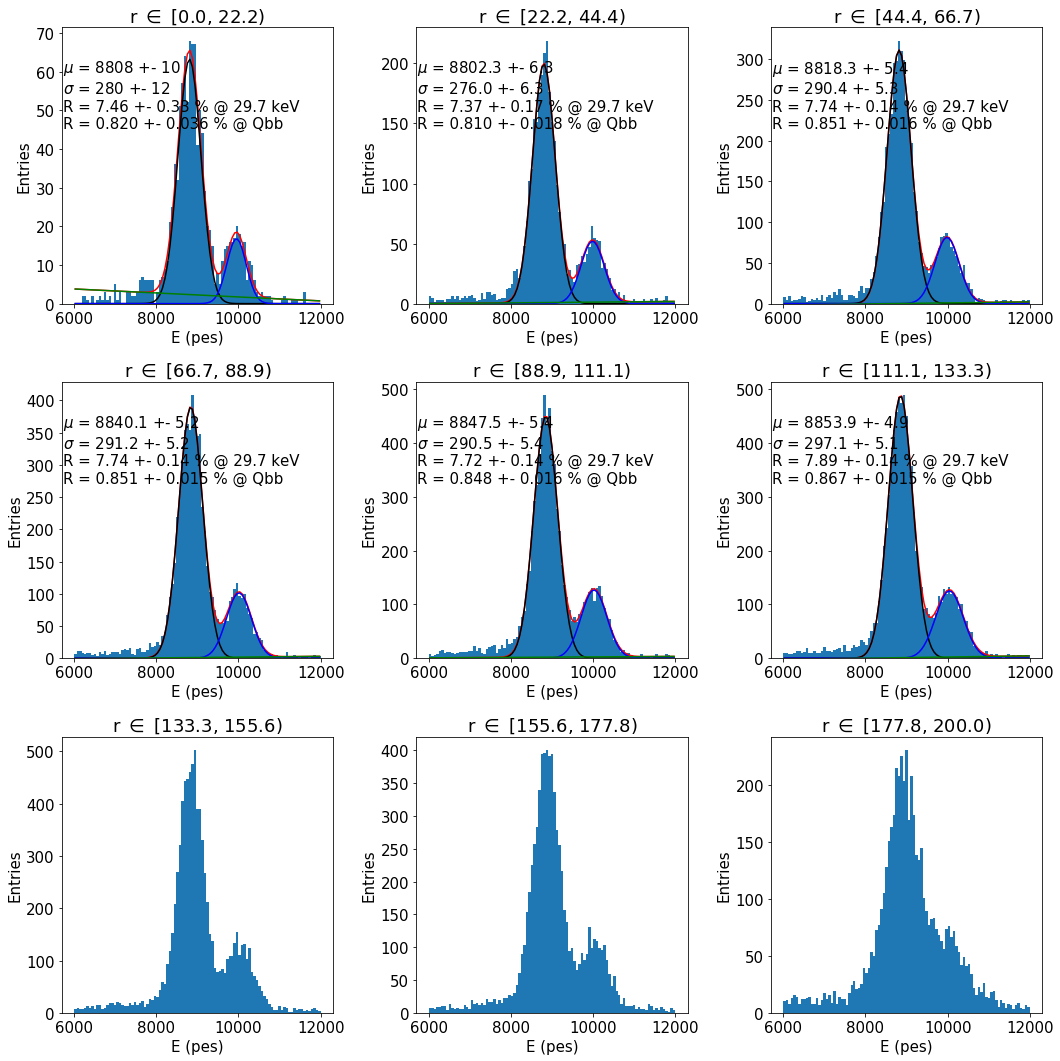

In [36]:
nx     = 9
xbins  = np.linspace(0, 200, nx+1)

fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                        fitf.gauss  (x, *args[3:6]) + \
                        fitf.polynom(x, *args[6: ])

ndat = len(PP)
seed = ndat    , XR1_fit_seed    , XR1_fit_seed*0.03, ndat    , XR2_fit_seed    , XR2_fit_seed*0.03,  np.mean(y)/10, -1e-2
low  = ndat/1e2, XR1_fit_seed*0.9, XR1_fit_seed*0.01, ndat/100, XR2_fit_seed*0.9, XR2_fit_seed*0.01, -np.mean(y)   , -1e+1
upp  = ndat*1e2, XR1_fit_seed*1.1, XR1_fit_seed*0.06, ndat*100, XR2_fit_seed*1.1, XR2_fit_seed*0.06,  np.mean(y)   , +1e+1

R_values   = np.zeros(nx)
u_R_values = np.zeros_like(R_values) 

plt.figure(figsize=(5*nx**0.5, 5*nx**0.5))
for i in range(nx):
    plt.subplot(nx//int(nx**0.5), nx//int(nx**0.5), i + 1)

    sel = coref.in_range(full.R.values, *xbins[i:i+2]) &\
          coref.in_range(E_xyztcorr   , *XR_range    )
    if np.count_nonzero(sel) < 200:
        continue

    try:
        E       = E_xyztcorr[sel]
        y, x, _ = hist(E, XR_range_bins, new_figure=False)
        title   = "r $\in$ [{:.1f}, {:.1f})".format(*xbins[i:i+2])
        labels("E (pes)", "Entries", title)

        f = fitf.fit(fun, x, y, seed, fit_range=XR_fit_range, sigma=poisson_sigma(y), bounds=(low, upp), maxfev=10000)

        assert not np.any(np.isclose(f.values, seed)), np.isclose(f.values, seed)
        assert not np.any(np.isclose(f.values, low) ), np.isclose(f.values, low )
        assert not np.any(np.isclose(f.values, upp) ), np.isclose(f.values, upp )

        plt.plot(x, f   .fn     (x                ), global_fit_draw_opt)
        plt.plot(x, fitf.gauss  (x, *f.values[ :3]), peak_1_fit_draw_opt)
        plt.plot(x, fitf.gauss  (x, *f.values[3:6]), peak_2_fit_draw_opt)
        plt.plot(x, fitf.polynom(x, *f.values[6: ]),    bkg_fit_draw_opt)
        plt.text(plt.xlim()[0] * 1.005, np.max(y)/1.5,
                 gausstext(f.values, f.errors, XR1_energy_keV))
        plt.ylim(0)

        res, res_bb   = resolution(f.values, f.errors, XR1_energy_keV)
        R_values  [i] = res_bb.value
        u_R_values[i] = res_bb.uncertainty
    except:
        continue
plt.tight_layout()

[ 0.81982019  0.80985061  0.85063205  0.85100135  0.84816379  0.86689712
  0.          0.          0.        ]


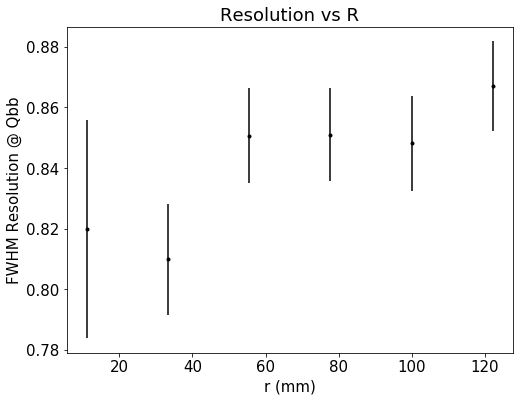

In [37]:
_x = shift_to_bin_centers(xbins)

sel = R_values > 0
print(R_values)

plt.errorbar(_x[sel], R_values[sel], u_R_values[sel], fmt="k.")
labels("r (mm)", "FWHM Resolution @ Qbb", "Resolution vs R")

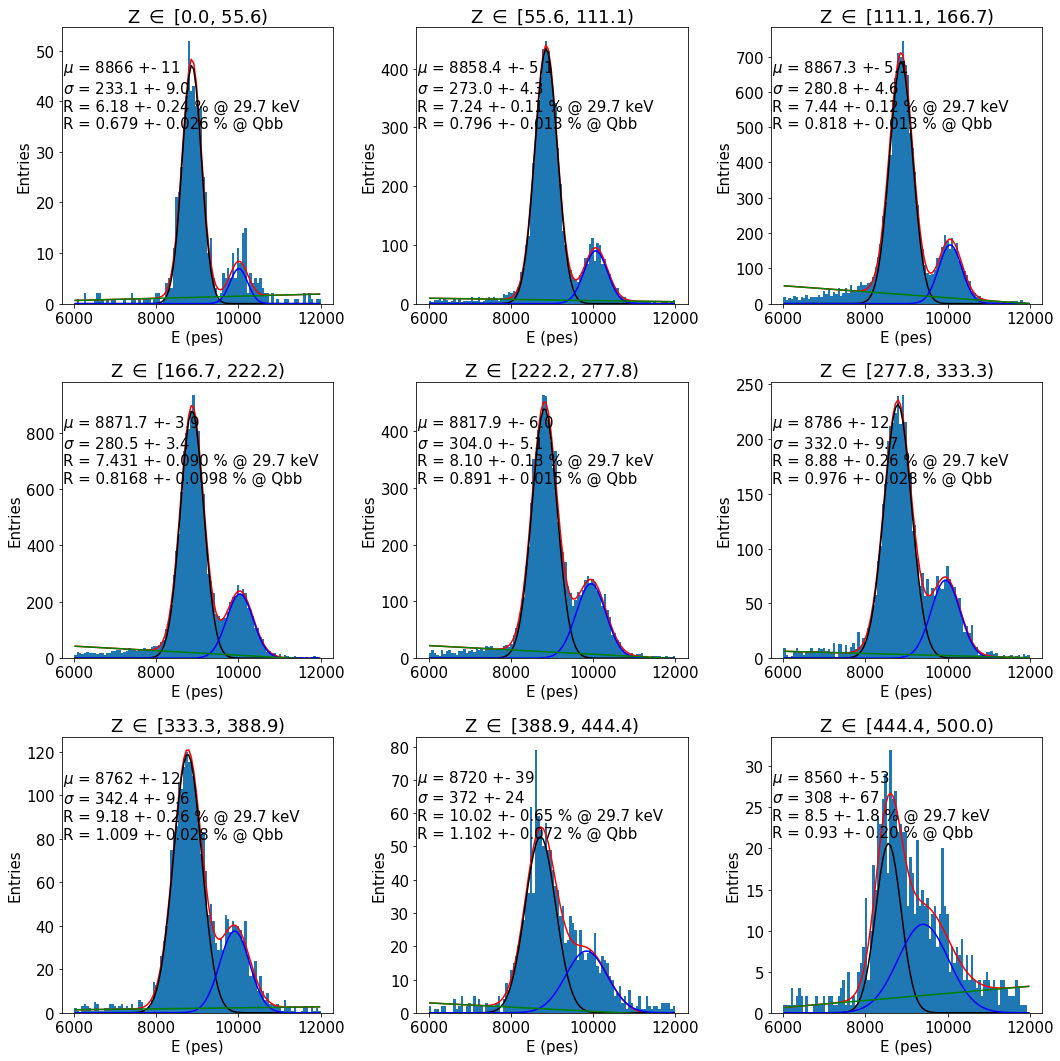

In [44]:
nx     = 9
xbins  = np.linspace(0, 500, nx+1)

fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                        fitf.gauss  (x, *args[3:6]) + \
                        fitf.polynom(x, *args[6: ])

ndat = len(XR)
#seed = 1e5, 9e3, 1e2, 1e4, 10e3, 1e2, 1e2, -1e-2
seed = ndat    , XR1_fit_seed    , XR1_fit_seed*0.03, ndat    , XR2_fit_seed    , XR2_fit_seed*0.03,  np.mean(y)/10 , -1e-2
low  = ndat/1e2, XR1_fit_seed*0.9, XR1_fit_seed*0.01, ndat/100, XR2_fit_seed*0.9, XR2_fit_seed*0.01, -np.mean(y)    , -1e+1
upp  = ndat*1e2, XR1_fit_seed*1.1, XR1_fit_seed*0.06, ndat*100, XR2_fit_seed*1.1, XR2_fit_seed*0.12,  np.mean(y)*1e3, +1e+1

R_values   = np.zeros(nx)
u_R_values = np.zeros_like(R_values) 

plt.figure(figsize=(5*nx**0.5, 5*nx**0.5))
for i in range(nx):
    plt.subplot(nx//int(nx**0.5), nx//int(nx**0.5), i + 1)

    sel = coref.in_range(full.Z.values, *xbins[i:i+2]) &\
          coref.in_range(E_xyztcorr, *XR_range)
    if np.count_nonzero(sel) < 200:
        continue

    try:
        E       = E_xyztcorr[sel]
        y, x, _ = hist(E, 100, (6e3, 12e3), new_figure=False)
        title   = "Z $\in$ [{:.1f}, {:.1f})".format(*xbins[i:i+2])
        labels("E (pes)", "Entries", title)

        f = fitf.fit(fun, x, y, seed, fit_range=(7200, 11e3), sigma=poisson_sigma(y),
                     bounds=(low, upp),
                     maxfev=10000)

        assert not np.any(np.isclose(f.values, seed)), np.isclose(f.values, seed)
        assert not np.any(np.isclose(f.values, low) ), np.isclose(f.values, low )
        assert not np.any(np.isclose(f.values, upp) ), np.isclose(f.values, upp )

        plt.plot(x, f   .fn     (x                ), global_fit_draw_opt)
        plt.plot(x, fitf.gauss  (x, *f.values[ :3]), peak_1_fit_draw_opt)
        plt.plot(x, fitf.gauss  (x, *f.values[3:6]), peak_2_fit_draw_opt)
        plt.plot(x, fitf.polynom(x, *f.values[6: ]),    bkg_fit_draw_opt)
        plt.text(plt.xlim()[0] * 1.005, np.max(y)/1.5,
                 gausstext(f.values, f.errors, 29.7))
        plt.ylim(0)

        res, res_bb   = resolution(f.values, f.errors, 29.7)
        R_values  [i] = res_bb.value
        u_R_values[i] = res_bb.uncertainty
    except:
        continue
plt.tight_layout()

[ 0.67912246  0.79622245  0.81791649  0.81679705  0.89070316  0.97600181
  1.00944063  1.10194019  0.9307994 ]


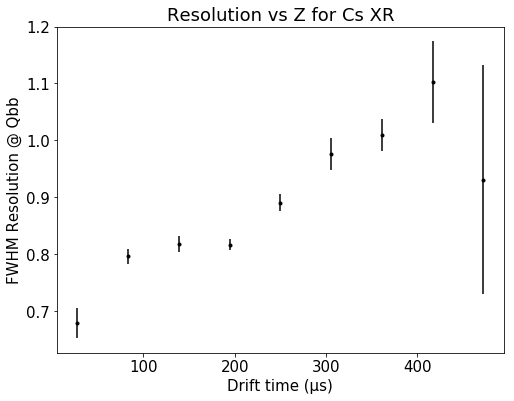

In [45]:
_x = shift_to_bin_centers(xbins)

sel = R_values > 0
print(R_values)

plt.errorbar(_x[sel], R_values[sel], u_R_values[sel], fmt="k.")
labels("Drift time (µs)", "FWHM Resolution @ Qbb", "Resolution vs Z for Cs XR")

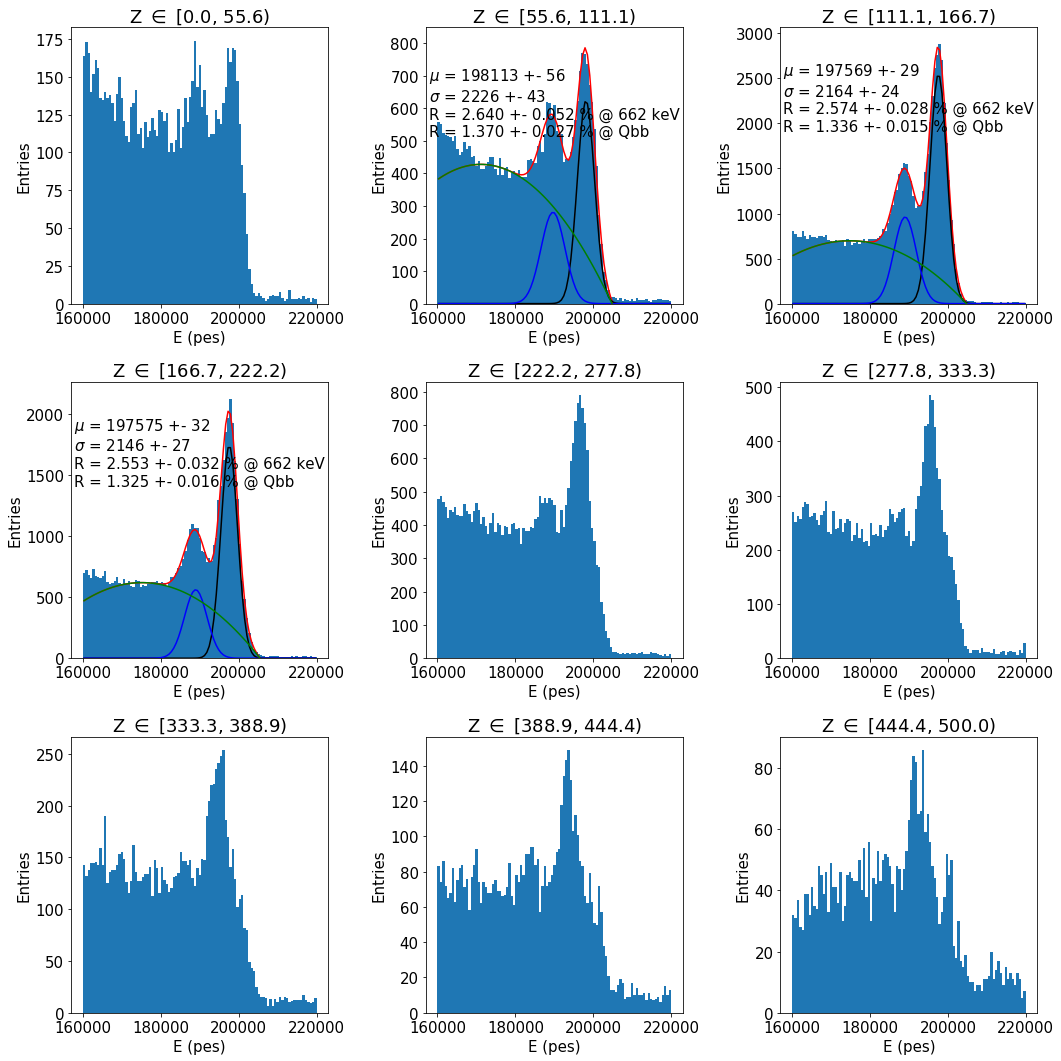

In [46]:
nz     = 9
zbins  = np.linspace(0, 500, nx+1)

fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                        fitf.gauss  (x, *args[3:6]) + \
                        fitf.polynom(x, *args[6: ])

ndat = len(PP)
seed = ndat    , PP1_fit_seed     , PP1_fit_seed*0.010, ndat    , PP2_fit_seed     , PP2_fit_seed*0.010,  2e3, 1e-2, -1e-7
low  = ndat*  0, PP1_fit_seed*0.99, PP1_fit_seed*0.003, ndat*  0, PP2_fit_seed*0.99, PP2_fit_seed*0.003, -1e5,-1e+3, -1e-1
upp  = ndat*1e8, PP1_fit_seed*1.01, PP1_fit_seed*0.020, ndat*1e8, PP2_fit_seed*1.01, PP2_fit_seed*0.030,  1e5, 1e+3, +1e-5

R_values   = np.zeros(nz)
u_R_values = np.zeros_like(R_values) 

plt.figure(figsize=(5*nz**0.5, 5*nz**0.5))
for i in range(nz):
    plt.subplot(nz//int(nz**0.5), nz//int(nz**0.5), i + 1)

    sel = coref.in_range(full.Z.values, *zbins[i:i+2]) &\
          coref.in_range(E_xyztcorr   , *PP_range    )
    if np.count_nonzero(sel) < 200:
        continue

    try:
        E       = E_xyztcorr[sel]
        y, x, _ = hist(E, PP_range_bins, new_figure=False)
        title   = "Z $\in$ [{:.1f}, {:.1f})".format(*zbins[i:i+2])
        labels("E (pes)", "Entries", title)

        f = fitf.fit(fun, x, y, seed, fit_range=PP_fit_range, sigma=poisson_sigma(y), bounds=(low, upp), maxfev=10000)

        assert not np.any(np.isclose(f.values, seed)), np.isclose(f.values, seed)
        assert not np.any(np.isclose(f.values, low) ), np.isclose(f.values, low )
        assert not np.any(np.isclose(f.values, upp) ), np.isclose(f.values, upp )

        plt.plot(x, f   .fn     (x                ), global_fit_draw_opt)
        plt.plot(x, fitf.gauss  (x, *f.values[ :3]), peak_1_fit_draw_opt)
        plt.plot(x, fitf.gauss  (x, *f.values[3:6]), peak_2_fit_draw_opt)
        plt.plot(x, fitf.polynom(x, *f.values[6: ]),    bkg_fit_draw_opt)
        plt.text(plt.xlim()[0] * 1.005, np.max(y)/1.5,
                 gausstext(f.values, f.errors, PP1_energy_keV))
        plt.ylim(0)

        res, res_bb   = resolution(f.values, f.errors, PP1_energy_keV)
        R_values  [i] = res_bb.value
        u_R_values[i] = res_bb.uncertainty
    except:
        continue
plt.tight_layout()

In [ ]:
_z = shift_to_bin_centers(zbins)

sel = R_values > 0
print(R_values)

plt.errorbar(_z[sel], R_values[sel], u_R_values[sel], fmt="k.")
labels("Drift time (µs)", "FWHM Resolution @ Qbb", "Resolution vs Z for Cs PP")